# Descan + STEM Overfocus procedure

Suppose we want to calibriate and verify the experimental microscope parameters of a fourdstem dataset which suffers from descan error - 

This notebook shows that using three vacuum reference datasets, taken at three *known* camera lengths (e.g. calibrated with polycrystalline gold diffraction rings), one can characterise the descan error matrix of the microscope. 

In [1]:
import jax
jax.config.update("jax_platform_name", "cpu")

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import copy
import jax.numpy as jnp
import libertem.api as lt
from libertem.udf.sum import SumUDF, RegressionOptions
from libertem.udf.com import CoMUDF
from libertem.udf.masks import ApplyMasksUDF
from skimage.measure import label, regionprops
from concurrent.futures import ProcessPoolExecutor

In [3]:
from microscope_calibration.model import ModelParameters, DescannerErrorParameters
from microscope_calibration.generate import generate_dataset_from_image
from microscope_calibration.interactive import interactive_window
from microscope_calibration.fitting import fit_descan_error_matrix

In [4]:
ctx = lt.Context.make_with("inline")

This notebook assumes you know the *pixel size* of your detector, and have acquired three overfocus dataset acquired at a *known camera lengths*, calibrated using some other method.

To begin we will generate this data so that this notebook is standalone.

## 0 - Generate data

In [5]:
sample_image = plt.imread(r"SilverFast_Resolution_Target_USAF_1951.png")[:, :, 0]
sample_image = sample_image[1:-1, 1:-1]
sample_image.shape

(206, 213)

In [ ]:
# Create a random descan error matrix
descan_error = DescannerErrorParameters(
        pxo_pxi=np.random.uniform(-5, 5),
        pxo_pyi=np.random.uniform(-5, 5),
        pyo_pxi=np.random.uniform(-5, 5),
        pyo_pyi=np.random.uniform(-5, 5),
        sxo_pxi=np.random.uniform(-5, 5),
        sxo_pyi=np.random.uniform(-5, 5),
        syo_pxi=np.random.uniform(-5, 5),
        syo_pyi=np.random.uniform(-5, 5),
        offpxi=np.random.uniform(-0.04, 0.04),
        offsxi=np.random.uniform(-0.04, 0.04),
        offpyi=np.random.uniform(-0.04, 0.04),
        offsyi=np.random.uniform(-0.04, 0.04)
    )

descan_error = DescannerErrorParameters(*descan_error)
params = ModelParameters(
    semi_conv=0.1,
    defocus=0.1,  # Distance from the crossover to the sample
    camera_length=1.0,  # Distance from the point source to the detector
    scan_shape=(32, 32),  # YX!
    det_shape=(65, 65),  # YX!
    scan_step=(0.001, 0.001),  # YX!
    det_px_size=(0.01, 0.01),  # YX!
    scan_rotation=0.,
    descan_error=descan_error,
    flip_y=False,
)

In [7]:
datasets = {}
clengths = (0.5, 1.0, 1.5)
with ProcessPoolExecutor(max_workers=3) as p:
    futures = []
    for cl in clengths:
        _params = copy.deepcopy(params)
        _params["camera_length"] = cl
        f = p.submit(generate_dataset_from_image, _params, sample_image, method="linear", progress=False)
        futures.append(f)
    
    for f, cl in zip(futures, clengths):
        data = f.result()
        datasets[cl] = ctx.load("memory", data=data, num_partitions=1)

## 1 - Determine approximate semiconvergence angle

We can determine an approximate $\alpha$ by measuring the radius of the transmitted beam in pixels, and using the pixel size and camera length to measure the angle of the triangle with origin at the point source.

In [ ]:
guesses = []
for cl in datasets.keys():
    det_px_size = min(params["det_px_size"])
    sy, sx = datasets[cl].shape.nav
    pick_a = ctx.create_pick_analysis(datasets[cl], sx // 2, sy // 2)
    frame = ctx.run(pick_a).intensity.raw_data
    radius = (
        max(
            regionprops(label(frame > frame.max() * 0.5)), key=lambda r: r.area
        ).equivalent_diameter
        / 2
    )
    semi_conv_guess = float(np.atan2(radius * det_px_size, cl)) # Still in small angle approximation, so atan2 should make no difference.
    guesses.append(semi_conv_guess)
    print(f"Camera length: {cl}, Approximate semiconv: {semi_conv_guess:.3f}, True value {params['semi_conv']}")

semi_conv_guess = np.mean(guesses)
print(f"Average approximte semiconv: {semi_conv_guess:.3f}, True value {params['semi_conv']}")

Camera length: 0.5, Approximte semiconv: 0.102, True value 0.1
Camera length: 1.0, Approximte semiconv: 0.098, True value 0.1
Camera length: 1.5, Approximte semiconv: 0.094, True value 0.1
Average approximte semiconv: 0.098, True value 0.1


## 2 - Visualise descan error

Just for visualisation, we start with a sum image of all dataset frames, and the CoM shift magnitude relative to the frame centre for each scan position:

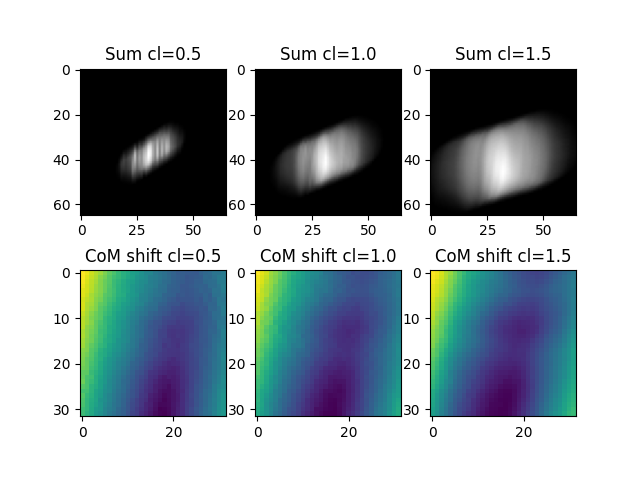

In [9]:
fig, axs = plt.subplots(2, 3)

com_r = {}
com_udf = CoMUDF.with_params()
for i, (cl, ds) in enumerate(datasets.items()):
    sum_res, com_res = ctx.run_udf(ds, [SumUDF(), com_udf])
    com_r[cl] = com_res
    axs[0, i].imshow(sum_res["intensity"].data, cmap="gray")
    axs[0, i].set_title(f"Sum cl={cl}")
for i, (cl, ds) in enumerate(datasets.items()):
    axs[1, i].imshow(com_r[cl]["magnitude"].data)
    axs[1, i].set_title(f"CoM shift cl={cl}")

We can see that there is more descan error at longer camera lengths, meaning we have an error dependent on the slope of the rays leaving the descanner.

## 3 - Determine parameters with Descan Error fixed via LiberTem COM analysis

Even in the presence of descan error, we can reconstruct a single dataset to determine the scan geometry and defocus. The result will be distorted, but should still be sharp when the right parameters are found. We will use an approximate input scan step, but no knowledge of the defocus value. 

In [ ]:
sy, sx = ds.shape.sig.to_tuple()
mask_px = sy // 2, sx // 2


def mask_factory():
    mask = np.zeros((sy, sx), dtype=np.float32)
    mask[mask_px] = 1.0
    return mask


masks_udf = ApplyMasksUDF(
    [mask_factory],
    use_torch=False,
    use_sparse=False,
    mask_count=1,
)

fig, axs = plt.subplots(2, 3)

for i, (cl, ds) in enumerate(datasets.items()):
    masks_shifted_udf = ApplyMasksUDF(
        [mask_factory],
        use_torch=False,
        use_sparse=False,
        mask_count=1,
        shifts=ApplyMasksUDF.aux_data(
            np.round(com_r[cl]["raw_shifts"].data).astype(int),
            dtype=int,
            kind="nav",
            extra_shape=(2,),
        ),
    )

    sum_res, com_res = ctx.run_udf(ds, [masks_udf, masks_shifted_udf])

    axs[0, i].imshow(sum_res["intensity"].data)
    axs[0, i].set_title(f"Point cl={cl}")
    axs[1, i].imshow(com_res["intensity"].data)
    axs[1, i].set_title(f"Shifted point cl={cl}")

    cl = 1.0
ds = datasets[cl]
det_px_size = (0.004, 0.004)  # YX!
pxshifts = px_shifts_matrix[cl]

nav_shape = ds.shape.nav
rand_nav_x, rand_nav_y = (
    np.random.randint(0, nav_shape[0]),
    np.random.randint(0, nav_shape[1]),
)

pick_a = ctx.create_pick_analysis(ds, rand_nav_x, rand_nav_y)
frame = ctx.run(pick_a).intensity.raw_data
shift = shifts[1.0][rand_nav_y, rand_nav_x]
frame = np.roll(frame, -1 * shift, axis=(0, 1))
radius = (
    max(
        regionprops(label(frame > frame.max() * 0.5)), key=lambda r: r.area
    ).equivalent_diameter
    / 2
)
semi_conv_guess = (radius * det_px_size[0]) / cl

In [ ]:
guess_params = copy.deepcopy(params)
cl = 1.0
guess_params["camera_length"] = cl
guess_params["semi_conv"] = semi_conv_guess
guess_params["defocus"] = 0.
guess_params["scan_step"] = np.asarray(guess_params["scan_step"]) * np.random.uniform(0.8, 1.2)
guess_params["scan_rotation"] = 0.
window, model_parameters = interactive_window(ctx, datasets[cl], guess_params)
window

BokehModel(combine_events=True, render_bundle={'docs_json': {'eb437f96-82fb-4fcd-9091-c242b01f2d6f': {'version…

## 4 - Descan error fit

With these parameters determined and more certainty on the input coordinate scan coordinates, we can then solve simultaneously on the three datasets to determine the descan error matrix that describes the microscope experiment. This descan error matrix will determine the propagation matrix of the microscope that describes the descan error dependance on camera length, and enable us to correct for astigmatism in the disks also.

In [13]:
descan_error_params_fit = fit_descan_error_matrix(model_parameters, com_r, num_samples=100)

print("Fitted versus Known descan error parameters:")
print(f"{'Parameter':20s}{'Fitted Value':25s}{'Known Value':25s}")
print("-" * 70)
for key in descan_error_params_fit._fields:
    fitted_val = getattr(descan_error_params_fit, key)
    known_val = getattr(descan_error, key)
    print(f"{key:20s}{f'{fitted_val:+.3f}':25s}{f'{known_val:+.3f}':25s}")


Fitted versus Known descan error parameters:
Parameter           Fitted Value             Known Value              
----------------------------------------------------------------------
pxo_pxi             +3.078                   +3.584                   
pxo_pyi             +0.598                   +0.688                   
pyo_pxi             +3.509                   +4.059                   
pyo_pyi             -1.503                   -1.902                   
sxo_pxi             +3.822                   +4.639                   
sxo_pyi             -2.041                   -2.303                   
syo_pxi             -0.596                   -0.649                   
syo_pyi             -0.256                   +0.021                   
offpxi              -0.012                   -0.012                   
offpyi              -0.031                   -0.031                   
offsxi              +0.006                   +0.005                   
offsyi              -0.038      

## Show final result

In [ ]:
model_parameters['descan_error'] = descan_error_params_fit
model_parameters['camera_length'] = 1.0
window, model_parameters = interactive_window(ctx, datasets[cl], guess_params)
window

BokehModel(combine_events=True, render_bundle={'docs_json': {'d4df7294-97f2-4fe9-aea5-f4257d654e5a': {'version…